In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
import pandas as pd
data = pd.read_csv("/content/yt.csv", skiprows=[2471])
data.head(10)

,Title,Videourl,Category,Description
0,Madagascar Street Food!!! Super RARE Malagasy ...,/watch?v=EwBA1fOQ96c,Food,🎥GIANT ALIEN SNAIL IN JAPAN! » https://youtu.b...
1,42 Foods You Need To Eat Before You Die,/watch?v=0SPwwpruGIA,Food,This is the ultimate must-try food bucket list...
2,Gordon Ramsay’s Top 5 Indian Dishes,/watch?v=upfu5nQB2ks,Food,We found 5 of the best and most interesting In...
3,How To Use Chopsticks - In About A Minute 🍜,/watch?v=xFRzzSF_6gk,Food,You're most likely sitting in a restaurant wit...
4,Trying Indian Food 1st Time!,/watch?v=K79bXtaRwcM,Food,HELP SUPPORT SINSTV!! Shop Our Sponsors!\nLast...
5,Blippi Tours the Chocolate Factory | Learn abo...,/watch?v=uSIb-Wbyx6Y,Food,After Blippi eats his vegetables Blippi takes ...
6,EGYPT: Vegetarian food | Mobile Sim | Indian S...,/watch?v=Gozaqmg6hmk,Food,"http://bit.ly/subscribeMT\nIn this video, you ..."
7,Chinese Street Food Liuhe Tourist Night Market,/watch?v=H0xKYgUX3zI,Food,Trying many different kinds of chinese street ...
8,India's Biggest food FESTIVAL | food truck fes...,/watch?v=NpOVNb1keoc,Food,Alright guys i hope you liked my video.\nAbout...
9,Street Food in Madagascar's Biggest City!!! Ze...,/watch?v=OXHHNBVt0pw,Food,🎥VILLAGE FOOD IN MADAGASCAR! » https://youtu.b...


In [54]:
print(data.shape)
print(data.isnull().values.any())

(2470, 4)
False


In [55]:
data=data.dropna()
print(data.isnull().values.any())

False


In [56]:
Category=data['Category'].value_counts()
print(Category.shape)
print(Category)

(2,)
Food             1828
manufacturing     642
Name: Category, dtype: int64


In [57]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))
#Stemmering the word
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        #Removing link
        url_pattern = r'((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?'
        total_text = re.sub(url_pattern, ' ', total_text)
        #removing email address
        email_pattern =r'[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+'
        total_text = re.sub(email_pattern, ' ', total_text)
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()

        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                word=(sno.stem(word))
                string += word + " "

        data[column][index] = string

In [58]:
#text processing stage.
start_time = time.perf_counter()
for index, row in data.iterrows():
    if type(row['Description']) is str:
        preprocessing(row['Description'], index, 'Description')
print('Time took for preprocessing the text :',time.perf_counter() - start_time, "seconds")

Time took for preprocessing the text : 6.824330219999979 seconds


In [59]:
data.head(10)

,Title,Videourl,Category,Description
0,Madagascar Street Food!!! Super RARE Malagasy ...,/watch?v=EwBA1fOQ96c,Food,giant alien snail japan go tour madagascar get...
1,42 Foods You Need To Eat Before You Die,/watch?v=0SPwwpruGIA,Food,ultim must tri food bucket list burger dip che...
2,Gordon Ramsay’s Top 5 Indian Dishes,/watch?v=upfu5nQB2ks,Food,found 5 best interest indian recip channel inc...
3,How To Use Chopsticks - In About A Minute 🍜,/watch?v=xFRzzSF_6gk,Food,like sit restaur set chopstick hand say video ...
4,Trying Indian Food 1st Time!,/watch?v=K79bXtaRwcM,Food,help support sinstv shop sponsor last longer b...
5,Blippi Tours the Chocolate Factory | Learn abo...,/watch?v=uSIb-Wbyx6Y,Food,blippi eat veget blippi take tour chocol facto...
6,EGYPT: Vegetarian food | Mobile Sim | Indian S...,/watch?v=Gozaqmg6hmk,Food,video see hunt best mobil network egypt base f...
7,Chinese Street Food Liuhe Tourist Night Market,/watch?v=H0xKYgUX3zI,Food,tri mani differ kind chines street food liuh t...
8,India's Biggest food FESTIVAL | food truck fes...,/watch?v=NpOVNb1keoc,Food,alright guy hope like video aim find somewhat ...
9,Street Food in Madagascar's Biggest City!!! Ze...,/watch?v=OXHHNBVt0pw,Food,villag food madagascar go tour madagascar get ...


In [60]:
y_true = data['Category'].values
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [61]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cv data:', cv_df.shape[0])

Number of data points in train data: 1580
Number of data points in test data: 494
Number of data points in cv data: 396


Food             1169
manufacturing     411
Name: Category, dtype: int64
Distribution of y in train


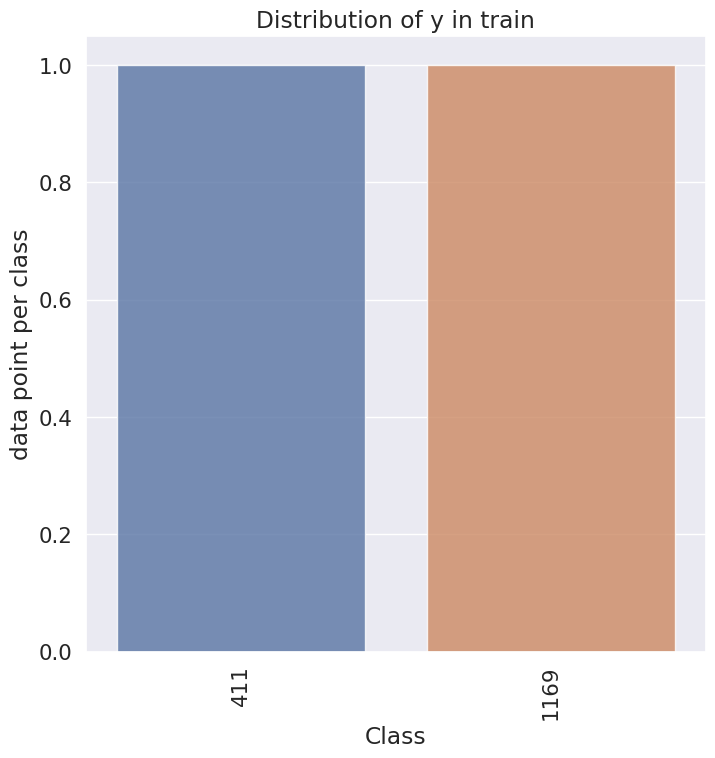

Food             366
manufacturing    128
Name: Category, dtype: int64
Distribution of y in test


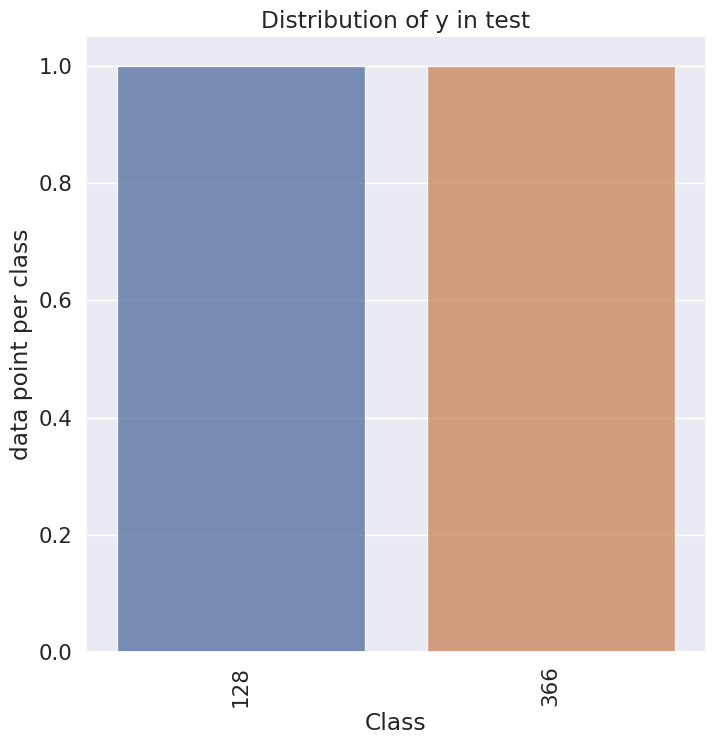

Food             293
manufacturing    103
Name: Category, dtype: int64
Distribution of y in cv


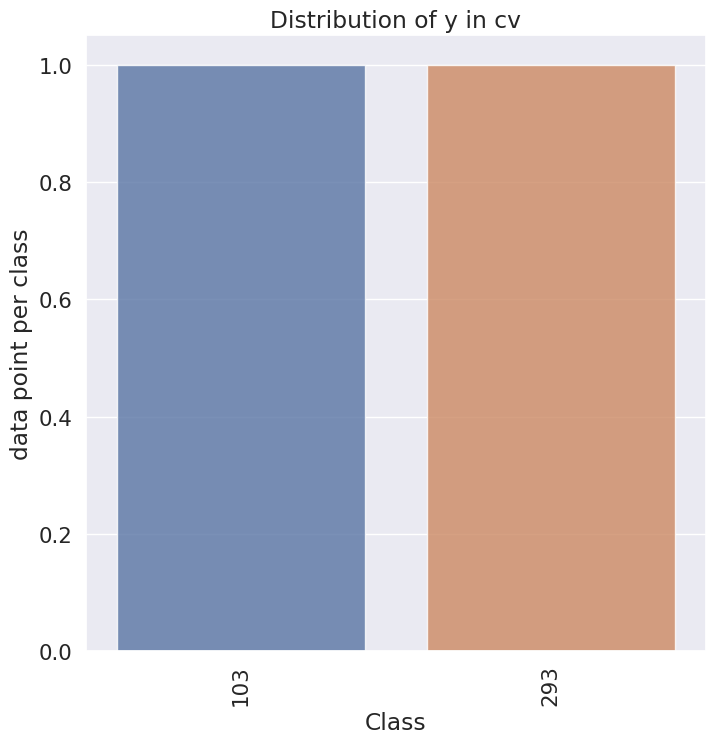

In [62]:
X_trainCategory=train_df['Category'].value_counts()
print(X_trainCategory)
print('Distribution of y in train')
plt.figure(figsize=(8,8))
sns.countplot(x=X_trainCategory, alpha=0.8)
plt.title('Distribution of y in train')
plt.ylabel('data point per class')
plt.xlabel('Class')
plt.xticks(rotation=90)
plt.show()




test_dfCategory=test_df['Category'].value_counts()
print(test_dfCategory)
print('Distribution of y in test')
plt.figure(figsize=(8,8))
sns.countplot(x=test_dfCategory, alpha=0.8)
plt.title('Distribution of y in test')
plt.ylabel('data point per class')
plt.xlabel('Class')
plt.xticks(rotation=90)
plt.show()

cv_dfCategory=cv_df['Category'].value_counts()
print(cv_dfCategory)
print('Distribution of y in cv')
plt.figure(figsize=(8,8))
sns.countplot(x=cv_dfCategory, alpha=0.8)
plt.title('Distribution of y in cv')
plt.ylabel('data point per class')
plt.xlabel('Class')
plt.xticks(rotation=90)
plt.show()


In [63]:
x_tr=train_df['Description']
x_test=test_df['Description']
x_cv=cv_df['Description']

In [64]:
bow = CountVectorizer()
x_tr_uni = bow.fit_transform(x_tr)
x_test_uni= bow.transform(x_test)
x_cv_uni= bow.transform(x_cv)

In [65]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_tr_tfidf = tf_idf_vect.fit_transform(x_tr)
x_test_tfidf = tf_idf_vect.transform(x_test)
x_cv_tfidf = tf_idf_vect.transform(x_cv)

In [66]:
def plotPrecisionRecall(y_test,y_pred):
    C = confusion_matrix(y_test, y_pred)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = ['Art&Music','Food','History','Sci&Tech','Manu','TravelBlog']


    print("-"*20, "Precision matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True,annot_kws={"size": 16}, fmt='g', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    # representing B in heatmap format
    print("-"*20, "Recall matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True,annot_kws={"size": 16}, fmt='g', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Accuracy on test set: 96.356%
Precision on test set: 0.947
Recall on test set: 0.960
F1-Score on test set: 0.953
-------------------- confusion matrix --------------------


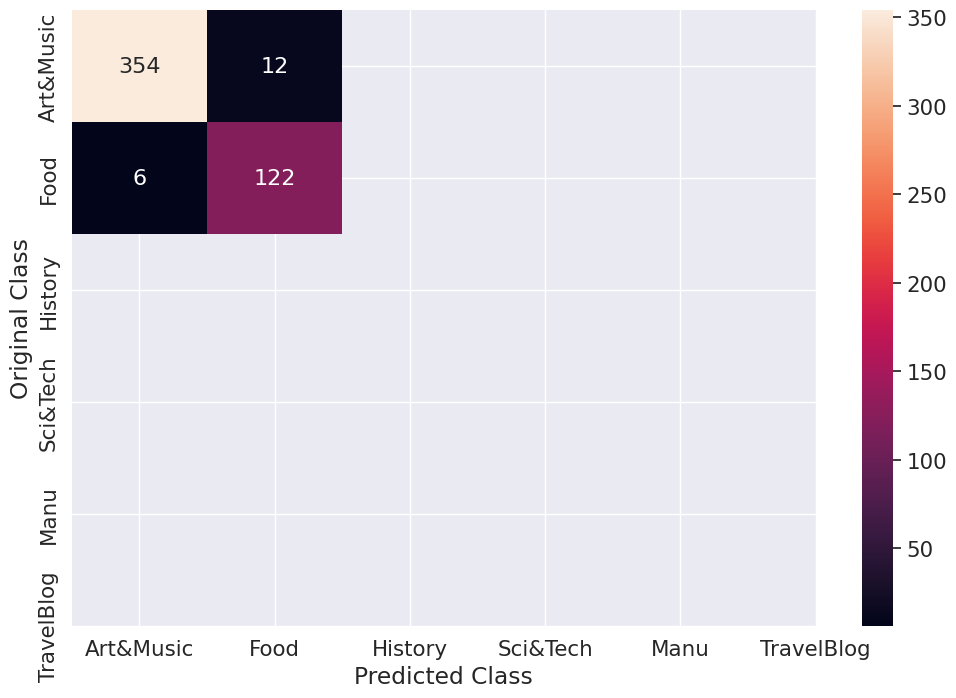

-------------------- Precision matrix --------------------


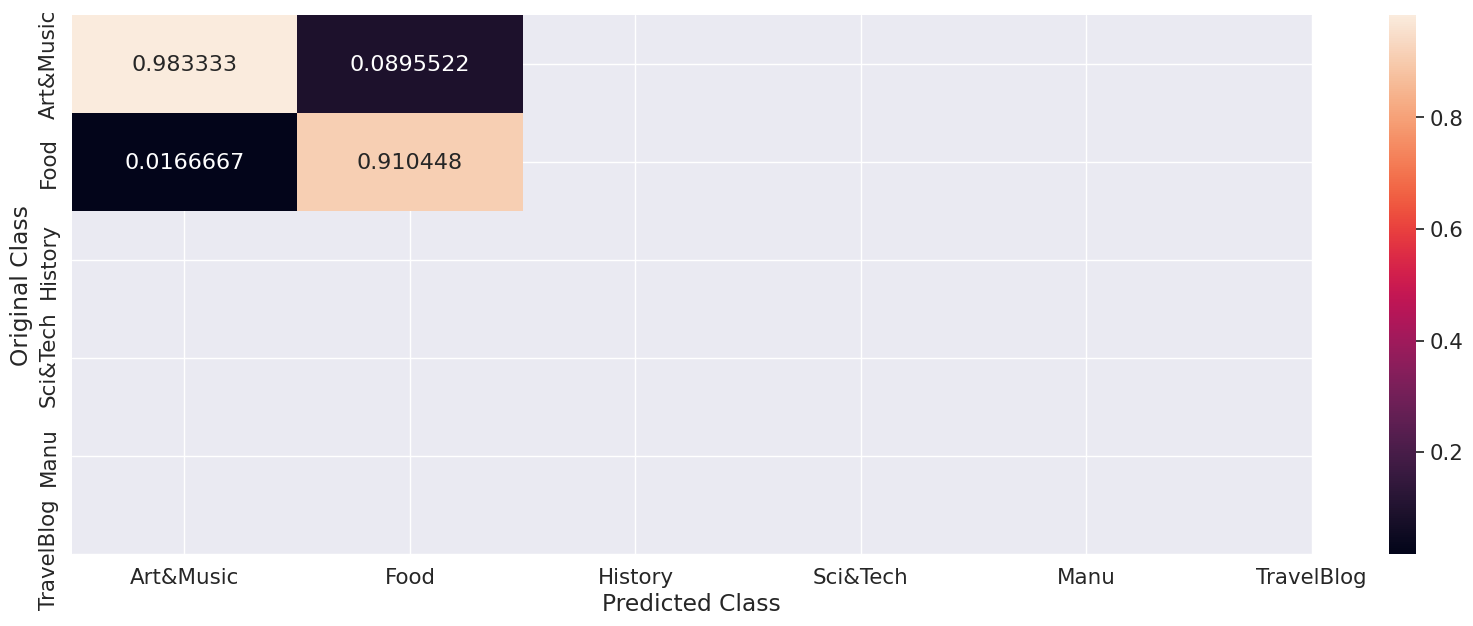

-------------------- Recall matrix --------------------


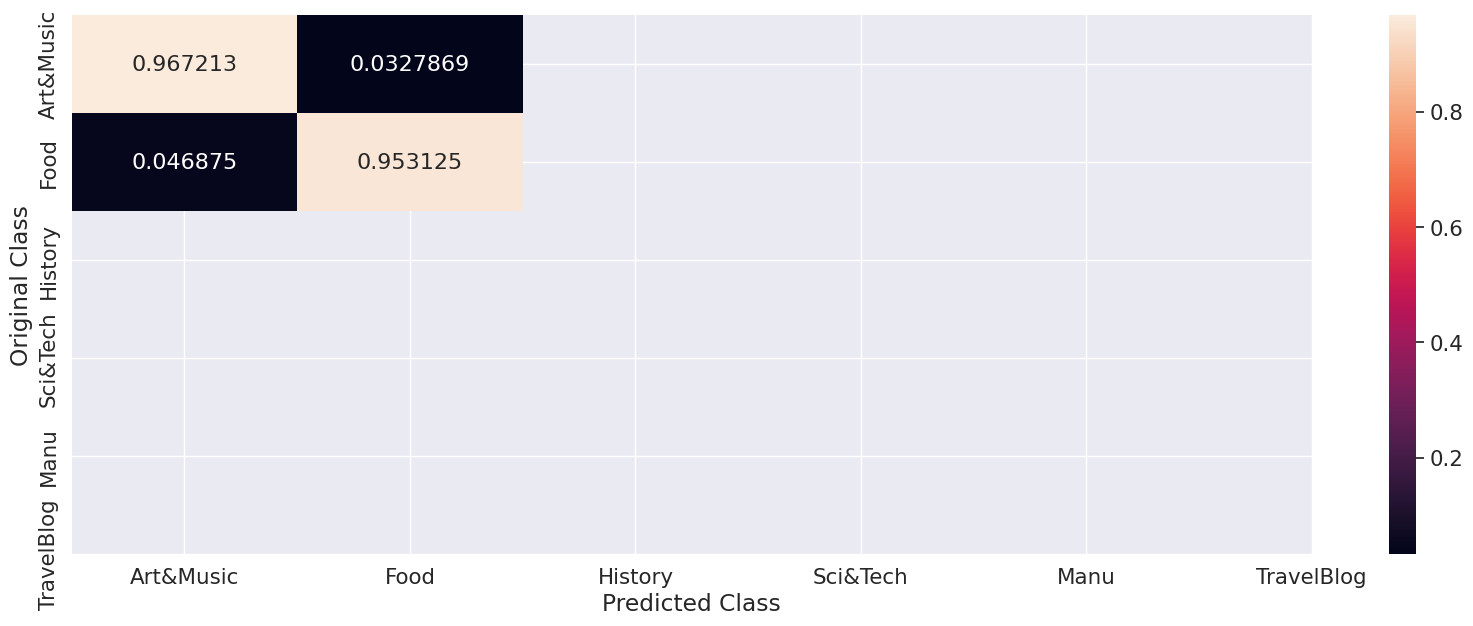

In [67]:
clf = SGDClassifier(loss = 'hinge', alpha = 0.01, class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1)
clf.fit(x_tr_uni,y_train)
y_pred = clf.predict(x_test_uni)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))

print("-"*20, "confusion matrix", "-"*20)
plt.figure(figsize=(12,8))
matrix=confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(matrix)
sns.set(font_scale=1.4)#for label size
labels = ['Art&Music','Food','History','Sci&Tech','Manu','TravelBlog']
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
plotPrecisionRecall(y_test,y_pred)

In [68]:
clf = SGDClassifier(loss = 'hinge', alpha =0.0001, class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1)
clf.fit(x_tr_tfidf,y_train)
y_pred = clf.predict(x_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))

print("-"*20, "confusion matrix", "-"*20)
plt.figure(figsize=(12,8))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(6),range(6))
sns.set(font_scale=1.4)#for label size
labels = ['Art&Music','Food','History','Sci&Tech','Manu','TravelBlog']
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
plotPrecisionRecall(y_test,y_pred)

Accuracy on test set: 97.773%
Precision on test set: 0.972
Recall on test set: 0.970
F1-Score on test set: 0.971
-------------------- confusion matrix --------------------


ValueError: ignored

<Figure size 1200x800 with 0 Axes>

In [ ]:
y_true = data['Category'].values
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.2)

In [ ]:
x_tr=X_train['Description']
x_test=test_df['Description']

In [ ]:
bow = CountVectorizer()
x_tr_uni = bow.fit_transform(x_tr)
x_test_uni= bow.transform(x_test)

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_tr_tfidf = tf_idf_vect.fit_transform(x_tr)
x_test_tfidf = tf_idf_vect.transform(x_test)

In [ ]:
RF= RandomForestClassifier(n_estimators=16,max_depth=130)
RF.fit(x_tr_uni,y_train)
y_pred =RF.predict(x_test_uni)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
print("-"*20, "confusion matrix", "-"*20)
plt.figure(figsize=(12,8))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(6),range(6))
sns.set(font_scale=1.4)#for label size
labels = ['Art&Music','Food','History','Sci&Tech','Manu','TravelBlog']
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
plotPrecisionRecall(y_test,y_pred)

In [ ]:
RF= RandomForestClassifier(n_estimators=20,max_depth=190)
RF.fit(x_tr_tfidf,y_train)
y_pred =RF.predict(x_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
print("-"*20, "confusion matrix", "-"*20)
plt.figure(figsize=(12,8))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(6),range(6))
sns.set(font_scale=1.4)#for label size
labels = ['Art&Music','Food','History','Sci&Tech','Manu','TravelBlog']
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g',xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

plotPrecisionRecall(y_test,y_pred)

In [ ]:
import joblib
# Saving the models
joblib.dump(clf, 'model.pkl')
['model.pkl']

In [ ]:
clf_loaded  = joblib.load('model.pkl')

In [ ]:
joblib.dump(bow, 'bow_model.pk1')



In [ ]:
joblib.dump(tf_idf_vect, 'tf_idf_model.pk1')


In [ ]:
bow_loaded = joblib.load('bow_model.pk1')
tf_idf_vect_loaded= joblib.load('tf_idf_model.pk1')